Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
tensor([2, 0, 1, 1, 1, 2, 1, 0, 0])
tensor(1344)


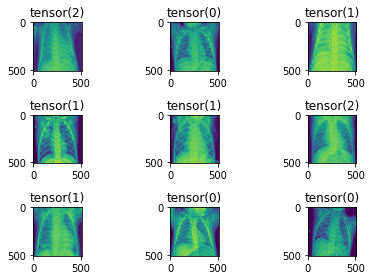

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=2f7192bc1ce663429026b69357177f91738ffa764e9ace19a6b9f1c3155839d6
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/My Drive/Colab Notebooks
importing Jupyter notebook from resNet50.ipynb
cuda:0


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



GroundTruth:  tensor(2)
Predicted:  tensor([1])


RuntimeError: ignored

In [1]:
import torch
import torchvision
import h5py
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

train_model = False
save_model = False
load_saved_model = False
no_out_classes = 3


train_set_img = []
train_set_label = []

def load_train_dataset():
    global train_set_img, train_set_label
    dataset_path = '/content/drive/My Drive/pneumonia_chest_X_ray_512x512_trainingDataset.h5'
    # dataset_path = '/content/drive/My Drive/charRecogTrainingDataset.h5'

    train_dataset = h5py.File(dataset_path, 'r')         # test set
    train_set_img = np.array(train_dataset['trainingset_image'][:]) # train set features
    train_set_label = np.array(train_dataset['trainingset_label'][:]) # train set labels

    train_set_img = torch.FloatTensor(train_set_img)
    train_set_label = train_set_label.astype(np.int)
    train_set_label = torch.LongTensor(train_set_label)

    print(train_set_label[0:9])
    print((train_set_label == torch.tensor(2)).sum())
    # print(names_set[0:9])

    # for i in range(500,505):
    #   plt.imshow(np.transpose(img_set[i], (1, 2, 0)))
    #   plt.show()

    i = 0
    rows = 3
    cols = 3
    axes = []
    fig=plt.figure()
    for a in range(rows*cols):
        b = train_set_img[i]
        axes.append( fig.add_subplot(rows, cols, a+1) )

        subplot_title=(str(train_set_label[i]))
        axes[-1].set_title(subplot_title)
         
        i += 1
        b = b.squeeze(0)
        b = b.numpy() # pyTorch tensor to numpy 
        #b = np.moveaxis(b, 0, 2)
        plt.imshow(b.astype('uint8'))
    fig.tight_layout()    
    plt.show()

load_train_dataset()


%pip install import_ipynb
import import_ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks

from resNet50 import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = ResNet50(img_channels=1, num_classes=no_out_classes).to(device)

model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True).to(device) 
model.fc = torch.nn.Linear(in_features=2048, out_features=3, bias=True)


### Define a Loss function and optimizer ###

import torch.optim as optim
weights = torch.tensor([1.88, 1., 1.88])
# weights = torch.tensor([1./1341, 1./2530, 1./1344])
# weights = torch.tensor([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.0000001)

### Train the network ###
def modelTraining():
  loss_values=[]
  for epoch in range(2):  # loop over the dataset multiple times
      running_loss = 0.0
      for i in range(len(train_set_label)):

          # get the inputs
          inputs = train_set_img[i]
          #inputs /= 255.0
          inputs = inputs.unsqueeze(0)

          labels = train_set_label[i]
          labels = torch.tensor([labels])

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs.to(device)).to(device)   # forward

          loss = criterion(outputs.to(device), labels.to(device))
          loss.backward()                             # backward
          optimizer.step()                            # optimize

          # print statistics
          running_loss += loss.item()
          if i % 3 == 2:    # print every 100 mini-batches
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
              loss_values.append(running_loss)
              running_loss = 0.0

  plt.plot(loss_values)
  plt.show()        
        
  print('Finished Training')

if train_model:
  modelTraining()
  
# save trained model:
PATH = '/content/drive/My Drive/pneumonia_training.pth'

if save_model:
  torch.save(net.state_dict(), PATH)

# load back the saved model
if load_saved_model:
  # net = Net()
  net.load_state_dict(torch.load(PATH))

## TEST on only few/single Dataset
test_images = [train_set_img[2], train_set_img[0], train_set_img[1]]
labels = [train_set_label[2],train_set_label[0],train_set_label[1]]
for i, image in enumerate(test_images):
    test_image = image
    # test_image = test_image.unsqueeze(0)

    # rgb_batch = np.repeat(test_image[..., np.newaxis], 3, -1)
    rgb_batch = np.stack((test_image,)*3, axis=-1)
    rgb_batch = np.transpose(rgb_batch, (0, 3, 1, 2))
    rgb_batch = torch.from_numpy(rgb_batch)
    outputs = model(rgb_batch.to(device))
    # outputs = net(test_image.to(device))
    _, predicted = torch.max(outputs, 1)
    
    # print('GroundTruth: ', train_set_label[i].to(device) )
    # print('Predicted: ',  predicted.to(device) )
    print('GroundTruth: ', train_set_label[i] )
    print('Predicted: ',  predicted)


# network performance on the whole dataset,
# AND accuracy of all classes
correct = 0
total = 0
class_correct = list(0. for i in range(no_out_classes))
class_total = list(0. for i in range(no_out_classes))
with torch.no_grad():
    for i in range(len(train_set_label)):
        images = train_set_img[i]
        # images = images.unsqueeze(0)

        labels = train_set_label[i]
        labels = torch.tensor([labels])

        rgb_batch = np.stack((images,)*3, axis=-1)
        rgb_batch = np.transpose(rgb_batch, (0, 3, 1, 2))
        rgb_batch = torch.from_numpy(rgb_batch)

        outputs = model(rgb_batch.to(device))
        # outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)

        # ----------------- for overall accuracy of model -----------------
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
        # ------- ------- ---------- -------- --------- --------- ---------

        # ----------------- for accuracy of each classes -------------------
        c = (predicted.to(device) == labels.to(device)).squeeze()
        class_correct[labels] += c.item()
        class_total[labels] += 1
        # ------- ------- ---------- -------- --------- --------- ---------


print('Accuracy of the network on the '+str(len(train_set_label))+' test images (%d/%d) : %.2f %%' % (correct, total ,100 * correct / total))

for i in range(no_out_classes):
    print('Accuracy of %5s  (%d/%d) : %.2f %%' % (i, class_correct[i], class_total[i] ,100 * class_correct[i] / class_total[i]))